In [1]:
import matplotlib.pyplot as plt
from scipy import interp
import numpy as np
from sklearn.metrics import auc

In [2]:
base_fpr = np.linspace(0,1,101)
base_recall = np.linspace(0,1,101)

In [3]:
def average_roc(tpr, fpr, base_fpr = np.linspace(0,1,101)):
    tpr_base = np.array([interp(base_fpr, fpr[i], tpr[i]) for i in range(tpr.shape[0])])
    mean_tpr = tpr_base.mean(axis=0)
    std_tpr = tpr_base.std(axis=0)
    tpr_up = np.minimum(mean_tpr + std_tpr, 1)
    tpr_low = mean_tpr - std_tpr
    return mean_tpr, std_tpr, tpr_up, tpr_low, tpr_base

def average_prec_recall(precision, recall, base_recall = np.linspace(0,1,101)):
    precision_base = np.array([interp(base_recall, recall[i], precision[i]) for i in range(len(precision))])
    mean_precision = precision_base.mean(axis=0)
    std_precision = precision_base.std(axis=0)
    precision_up = np.minimum(mean_precision + std_precision, 1)
    precision_low = mean_precision - std_precision
    return mean_precision[1:], std_precision[1:], precision_up[1:], precision_low[1:]

def compute_curves(tpr_path,fpr_path):
    tpr_ = np.load(tpr_path,allow_pickle = True)
    fpr_ = np.load(fpr_path,allow_pickle = True)
    
    precision_ = [precision(tpr_[i],fpr_[i]) for i in range(len(tpr_))]
    recall_ = tpr_

    mean_tpr_, std_tpr_, tprs_upper_, tprs_lower_, tpr_base = average_roc(tpr_,fpr_)  
    mean_precision_, std_precision_, precision_upper_, precision_lower_ = average_prec_recall(precision_,recall_)  
    auc_pr_ = np.mean(np.array([auc(recall_[i][1:], precision_[i][1:]) for i in range(len(recall_))]))
    auc_pr_std_ = np.std(np.array([auc(recall_[i][1:], precision_[i][1:]) for i in range(len(recall_))]))
    
    aucs_roc = np.array([auc(base_fpr,tpr_base[i]) for i in range(len(tpr_base))])
    auc_roc_mean = np.mean(aucs_roc)
    auc_roc_std = np.std(aucs_roc)
    
    return {"mean_tpr" : mean_tpr_,
            "std_tpr" : std_tpr_,
            "tprs_upper": tprs_upper_,
            "tprs_lower" : tprs_lower_,
            "mean_precision": mean_precision_,
            "std_precision": std_precision_,
            "precision_upper": precision_upper_,
            "precision_lower": precision_lower_,
            "auc_pr": auc_pr_,
            "auc_pr_std": auc_pr_std_,
           "auc": auc(base_fpr,mean_tpr_),
           "auc_mean" : auc_roc_mean,
           "auc_roc_std": auc_roc_std}

In [4]:
N_over_P = 5.0079435127978815
def precision(tpr,fpr):
    return tpr/(tpr+N_over_P*fpr)

In [5]:
curves_dict = {}

In [13]:
curves_dict["BPTF"] = compute_curves(tpr_path = "./comparisons_results/Setup1/model6_tpr.npy",
                                        fpr_path = "./comparisons_results/Setup1/model6_fpr.npy")
curves_dict["Static RF"] = compute_curves(tpr_path = "./comparisons_results/Setup1/model0_tpr.npy",
                                        fpr_path = "./comparisons_results/Setup1/model0_fpr.npy")
curves_dict["Dynamic RF"] = compute_curves(tpr_path = "./comparisons_results/Setup1/model1_tpr.npy",
                                        fpr_path = "./comparisons_results/Setup1/model1_fpr.npy")
curves_dict["Time-aware GRU"] = compute_curves(tpr_path = "./RNN/trained_models/GRU_tpr.npy",
                                        fpr_path = "./RNN/trained_models/GRU_fpr.npy")
curves_dict["GRU-ODE"] = compute_curves(tpr_path = "./RNN/trained_models/GRUODE_tpr.npy",
                                        fpr_path = "./RNN/trained_models/GRUODE_fpr.npy")


/home/edward/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/edward/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  
/home/edward/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  # Remove the CWD from sys.path while we load stuff.


In [14]:
color_code = {"BPTF": "blue", "Time-aware GRU":"green", "GRU-ODE":"yellow","Dynamic RF":"red","Static RF":"orange"}

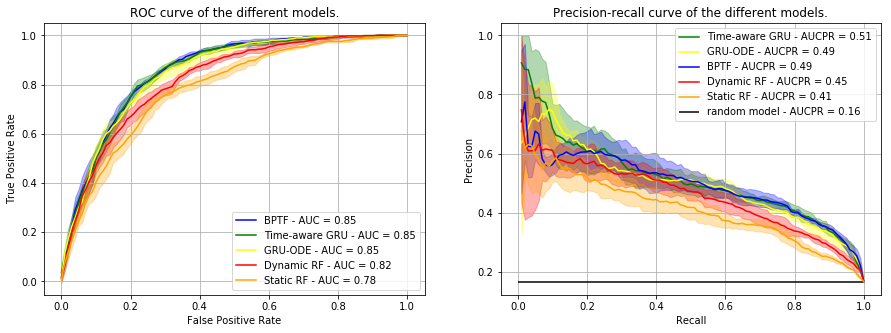

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (15,5))

for i,model_name in enumerate(["BPTF","Time-aware GRU","GRU-ODE","Dynamic RF","Static RF"]):
    auc = curves_dict[model_name]["auc"]
    
    ax1.plot(base_fpr, curves_dict[model_name]["mean_tpr"],color = color_code[model_name], label = f"{model_name} - AUC = {auc:.2f}")    
    ax1.fill_between(base_fpr, curves_dict[model_name]["tprs_lower"], curves_dict[model_name]["tprs_upper"], color=color_code[model_name], alpha=0.3)



ax1.legend()
ax1.set_title("ROC curve of the different models.")
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
ax1.grid()

ax2.hlines(y=(1113/6807),xmin= 0, xmax = 1,label = f"random model - AUCPR = {(1113/6807):.2f}")

for i,model_name in enumerate(["Time-aware GRU","GRU-ODE","BPTF","Dynamic RF","Static RF"]):
    auc_pr = curves_dict[model_name]["auc_pr"]
    ax2.plot(base_recall[1:], curves_dict[model_name]["mean_precision"], color = color_code[model_name], label = f"{model_name} - AUCPR = {auc_pr:.2f}")
    ax2.fill_between(base_recall[1:], curves_dict[model_name]["precision_lower"], curves_dict[model_name]["precision_upper"], color=color_code[model_name], alpha=0.3)

ax2.legend()
ax2.set_title("Precision-recall curve of the different models.")
ax2.set_xlabel("Recall")
ax2.set_ylabel("Precision")
ax2.grid()
#plt.savefig("aucpr.pdf")

fig.show()




fig.savefig("auc_AND_aucpr.pdf")
#plt.show()

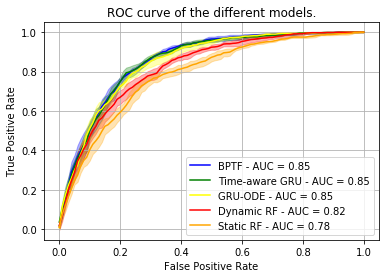

In [16]:
plt.figure()

for i,model_name in enumerate(["BPTF","Time-aware GRU","GRU-ODE","Dynamic RF","Static RF"]):
    auc = curves_dict[model_name]["auc"]
    
    plt.plot(base_fpr, curves_dict[model_name]["mean_tpr"],color = color_code[model_name], label = f"{model_name} - AUC = {auc:.2f}")    
    plt.fill_between(base_fpr, curves_dict[model_name]["tprs_lower"], curves_dict[model_name]["tprs_upper"], color=color_code[model_name], alpha=0.3)



plt.legend()
plt.title("ROC curve of the different models.")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid()

plt.savefig("auc.pdf")
plt.show()


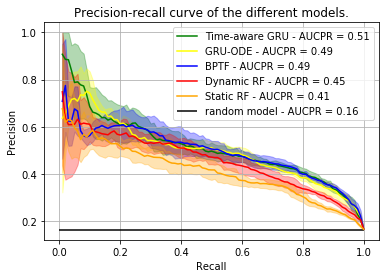

In [17]:
plt.figure()

plt.hlines(y=(1113/6807),xmin= 0, xmax = 1,label = f"random model - AUCPR = {(1113/6807):.2f}")

for i,model_name in enumerate(["Time-aware GRU","GRU-ODE","BPTF","Dynamic RF","Static RF"]):
    auc_pr = curves_dict[model_name]["auc_pr"]
    plt.plot(base_recall[1:], curves_dict[model_name]["mean_precision"], color = color_code[model_name], label = f"{model_name} - AUCPR = {auc_pr:.2f}")
    plt.fill_between(base_recall[1:], curves_dict[model_name]["precision_lower"], curves_dict[model_name]["precision_upper"], color=color_code[model_name], alpha=0.3)


plt.legend()
plt.title("Precision-recall curve of the different models.")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.savefig("aucpr.pdf")
plt.show()

curves_dict["Time-aware GRU"]["mean_precision"][80]

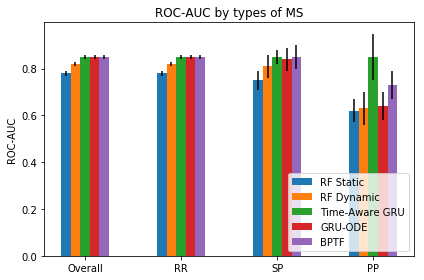

In [19]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

plot_idx = [0,1,3,5]

labels = np.array(['Overall', 'RR', 'PP_', 'SP', 'PR_', 'PP'])
static_means = np.array([0.78, 0.78, 0.67, 0.75, 0.54, 0.62])
dynamic_means = np.array([0.82, 0.82, 0.66, 0.81, 0.57, 0.63])
gru_means = np.array([0.85,0.85,0.82,0.85,0.88, 0.85])
gruode_means = np.array([0.85,0.85,0.66,0.84,0.64, 0.64])
bptf_means = np.array([0.85,0.85,0.69,0.85,0.68, 0.73])

static_stds = np.array([0.01, 0.01, 0.06, 0.04, 0.22, 0.05])
dynamic_stds = np.array([0.01, 0.01, 0.07, 0.05, 0.22, 0.07])
gru_stds = np.array([0.01,0.01,0.18,0.03,0.12, 0.10])
gruode_stds = np.array([0.01,0.01,0.05,0.05,0.26, 0.06])
bptf_stds = np.array([0.01,0.01,0.19,0.05,0.19, 0.06])

x = np.arange(len(labels[plot_idx]))  # the label locations
width = 0.1  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 2*width, static_means[plot_idx], width, yerr = static_stds[plot_idx], label='RF Static')
rects2 = ax.bar(x - width, dynamic_means[plot_idx], width, yerr = dynamic_stds[plot_idx], label='RF Dynamic')
rects3 = ax.bar(x , gru_means[plot_idx], width, yerr = gru_stds[plot_idx], label='Time-Aware GRU')
rects4 = ax.bar(x + width, gruode_means[plot_idx], width, yerr = gruode_stds[plot_idx], label='GRU-ODE')
rects5 = ax.bar(x + 2*width, bptf_means[plot_idx], width, yerr = bptf_stds[plot_idx], label='BPTF')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('ROC-AUC')
ax.set_title('ROC-AUC by types of MS')
ax.set_xticks(x)
ax.set_xticklabels(labels[plot_idx])
ax.legend(loc = "lower right")

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()